### n-gram Language Models, Word Sense disambiguation(LSA using SVD), LSTM




# Latent Semantic Analysis


 - A. Singular Value Decomposition (SVD) based distributed representation of text and documents. We use python libraries for matrix decomposition (scipy), and to demonstrate our work, we use the example dataset (Table 2) of "R. A. Harshman (1990). Indexing by latent semantic analysis. Journal of the American society for information science". 

 - B. Visualize (2-D) the documents and terms using library of our choice.

 - C. Implement a function that converts a query string to distributed representation and retrieves relevent documents. Visualize the the results as shown in Fig 1 of the paper.

### Input data

In [ ]:
#Dataset
c1 = 'Human machine interface for Lab ABC computer applications'
c2 = 'A survey of user opinion of computer system response time'
c3 = 'The EPS user interface management system'
c4 = 'System and human system engineering testing of EPS'
c5 = 'Relation of user-perceived response time to error measurement'
m1 = 'The generation of random, binary, unordered trees'
m2 = 'The intersection graph of paths in trees'
m3 = 'Graph minors IV: Widths of trees and well-quasi-ordering'
m4 = 'Graph minors: A survey'
documents = [c1, c2, c3, c4, c5, m1, m2, m3, m4]

In [ ]:
# TASK CELL

import string
import numpy as np
import math
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize.treebank import TreebankWordDetokenizer
warnings.filterwarnings("ignore")
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer

#-----


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Performing preprocessing of documents

In the below cell, we remove punctuations and keep only words which belong to nltk corpus

In [ ]:
def preprocess(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        preprocessed_message_list: a list of words containing the processed message. 

    '''
   
    message_cleaned = message.translate(str.maketrans('', '', string.punctuation)).lower()
    review_tokens = word_tokenize(message_cleaned)
    lemmatizer = WordNetLemmatizer()
    preprocessed_message_list = [word for word in review_tokens if lemmatizer.lemmatize(word) in words.words()]
    
    return preprocessed_message_list

### Verify preprocessed data

In [ ]:
for sent in documents:
    print(preprocess(sent))

['human', 'machine', 'interface', 'for', 'lab', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of']
['relation', 'of', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'widths', 'of', 'trees', 'and']
['graph', 'minors', 'a', 'survey']


##### Expected Output
```CPP
['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']
```

### Assign names to document names
In the below cell create a list of document names. It will be later used to visualize documents

In [ ]:
def createDocName(documents):
  '''
    Input:
        documents: list of documents.
    Output:
        doc_names: a list of document names. 

    '''
  doc_names = []
  for n in range(len(documents)):
    if n <5:
      name = 'c'+str(n+1)
      doc_names.append(name)
    else:
      name = 'm'+str(n-4)
      doc_names.append(name)
  
  return doc_names

In [ ]:
docName = createDocName(documents)
print(docName)

['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']


##### Expected Output
``` CPP
['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
```

### Words to Index mapping
Retrieve words from documents and create map of word and associate index to it

In [ ]:
def build_word_to_ix(documents, stopwords=None):
    '''
    Input:
        documents: list of documents
        stopwords: list of stopwords
    Output:
        doc_names: map of words and assoicated index. 

    '''
    word_to_ix = {}
    tokens = []
    for document in documents:
        documents_cleaned = document.translate(str.maketrans('', '', string.punctuation)).lower()
        tokens.append(word_tokenize(documents_cleaned))
    words = np.concatenate(tokens)
    stop_words = [word for word in words if not word in stopwords]
    arr = []
    for words in stop_words:
        if words not in arr:
            arr.append(words)
    ind = -1
    for word in arr:
        if np.concatenate(tokens).tolist().count(word) > 1:
            ind += 1
            word_to_ix[word] = ind
    
    return word_to_ix

In [ ]:
word_to_ix = build_word_to_ix(documents, stop_words)
print(word_to_ix)

{'human': 0, 'interface': 1, 'computer': 2, 'survey': 3, 'user': 4, 'system': 5, 'response': 6, 'time': 7, 'eps': 8, 'trees': 9, 'graph': 10, 'minors': 11}


##### Expected Output
```CPP
{'human': 0, 'interface': 1, 'computer': 2, 'user': 3, 'survey': 4, 'system': 5, 'time': 6, 'response': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}
```

### Document-Terms count matrix

In [ ]:
def build_td_matrix(documents, word_to_ix):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
    Output:
        td_matrix: matrix of count of words in documents, each row 
            represent a word and each column represent a document

    '''
    td_matrix = np.zeros((len(word_to_ix), len(documents)))
    for row, word in enumerate(word_to_ix.keys()):
        for column, doc in enumerate(documents):
                td_matrix[row, column] = preprocess(doc).count(word)
    return td_matrix

In [ ]:
X = build_td_matrix(documents, word_to_ix)
print(X)

[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


##### Expected Output
```CPP
[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 ```

### Singular Value Decomposition
Perform singular value decomposition of count matrix into term singular vector matrix, singular value matrix and document singular vector matrix
- To perform the singular value decompostion please check tutorial:
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [ ]:
def svd(documents, word_to_ix, rank):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
        rank: number of colums/rows to retain in decomposed matrix
    Output:
        Uk: term singular vector matrix
        Sk: singular value matrix
        Vk_t: transpose of document singular vector matrix
    '''
    Uk, Sk, Vk_t = np.linalg.svd(build_td_matrix(documents, word_to_ix))
    Uk = Uk[:, 0:rank]
    Sk = np.diag(Sk)[:, 0:rank]
    Sk = Sk[0:rank, 0:rank]
    Vk_t = np.transpose(Vk_t)
    Vk_t = Vk_t[:, 0:rank]
    return Uk, Sk, Vk_t

In [ ]:
Uk, Sk, Vk_t = svd(documents, word_to_ix, 2)
print(Uk)
print(Sk)
print(Vk_t)

[[-0.24173282 -0.08351582]
 [-0.20373945 -0.06188287]
 [-0.29784055 -0.01622574]
 [-0.2599895   0.21901915]
 [-0.34807902 -0.02743127]
 [-0.67804369 -0.14378558]
 [-0.27862967  0.01327545]
 [-0.27862967  0.01327545]
 [ 0.          0.        ]
 [-0.02689041  0.52450019]
 [-0.06301328  0.65217791]
 [-0.05373031  0.46770422]]
[[3.11204045 0.        ]
 [0.         2.52558288]]
[[-0.23885063 -0.0639949 ]
 [-0.68804121  0.02301546]
 [-0.39519479 -0.09229542]
 [-0.51343169 -0.14693122]
 [-0.17906558  0.01051278]
 [-0.00864076  0.20767491]
 [-0.02888899  0.46590358]
 [-0.04615428  0.65109022]
 [-0.12105662  0.53013555]]


##### Expected Output
```CPP 
[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.40359886  0.05707026]
 [-0.20591786  0.27364743]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]
 ```

### Visualize documents in 2D space

In [ ]:
#Visualize documents and print coordinates

VS = np.dot(Vk_t, Sk)

x = VS[:, 0]
y = VS[:, 1]

VS

array([[-0.74331283, -0.16162442],
       [-2.14121209,  0.05812745],
       [-1.22986216, -0.23309972],
       [-1.5978202 , -0.37108698],
       [-0.55725933,  0.02655089],
       [-0.02689041,  0.52450019],
       [-0.08990369,  1.1766781 ],
       [-0.143634  ,  1.64438232],
       [-0.37673309,  1.33890128]])

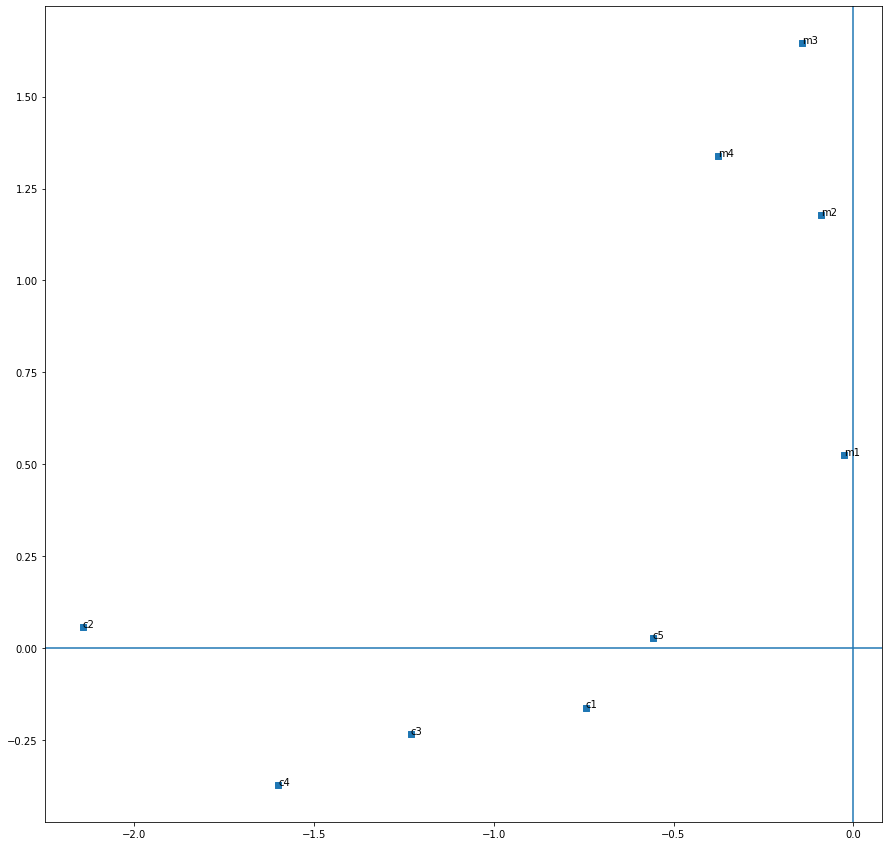

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(x, y, marker = 's')
for i in range(len(x)):
    plt.annotate(docName[i], (x[i], y[i]))
plt.axvline(x=0)
plt.axhline(y=0)
plt.show()

##### Expected
```CPP
[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]
```
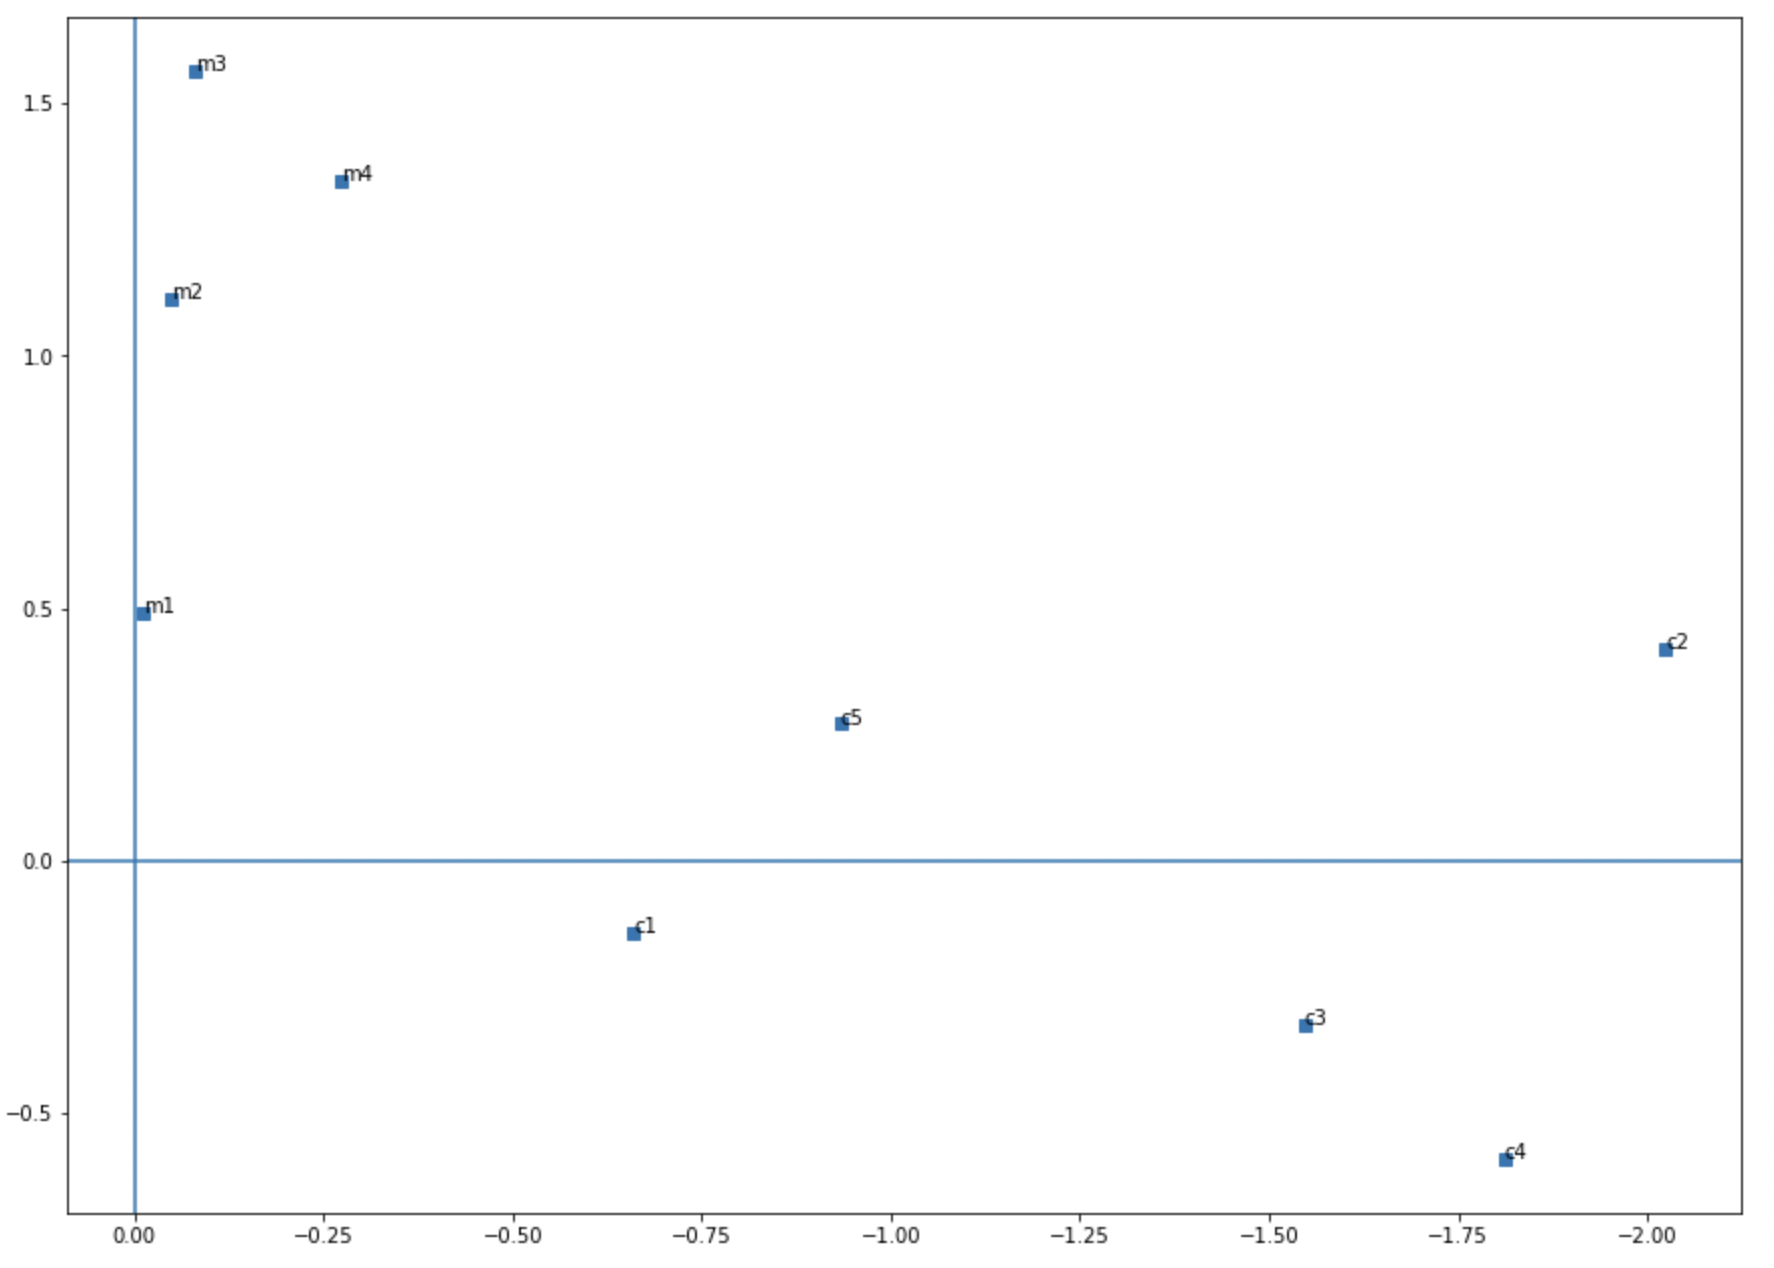

### Visualize terms in 2D space

In [ ]:
#Visualize terms and print coordinates

US = np.dot(Uk, Sk)

x1 = US[:, 0]
y1 = US[:, 1]

US

array([[-0.75228232, -0.21092612],
       [-0.63404542, -0.15629031],
       [-0.92689185, -0.04097944],
       [-0.80909783,  0.55315101],
       [-1.083236  , -0.06927995],
       [-2.11009939, -0.3631424 ],
       [-0.8671068 ,  0.03352824],
       [-0.8671068 ,  0.03352824],
       [ 0.        ,  0.        ],
       [-0.08368403,  1.32466871],
       [-0.19609989,  1.64712935],
       [-0.1672109 ,  1.18122578]])

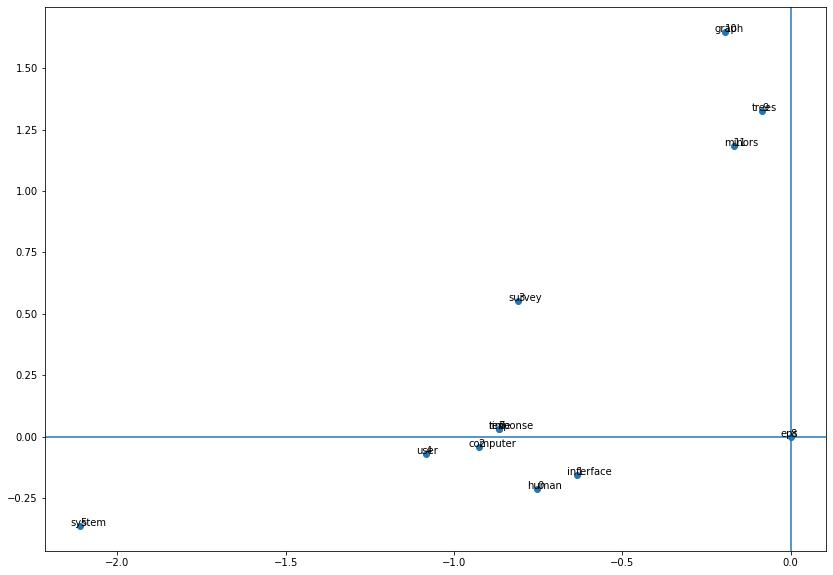

In [ ]:
terms = []
index = []
for key, value in word_to_ix.items():
    terms.append(key)
    index.append(value)

plt.figure(figsize=(14, 10))
plt.scatter(x1, y1)
for i in range(len(x1)):
    plt.annotate(terms[i], (x1[i] - 0.03, y1[i]))
    plt.annotate(index[i], (x1[i], y1[i]))
plt.axvline(x=0)
plt.axhline(y=0)

  

##### Expected
```CPP
[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-1.34837689  0.14505553]
 [-0.68794764  0.69552995]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]
```
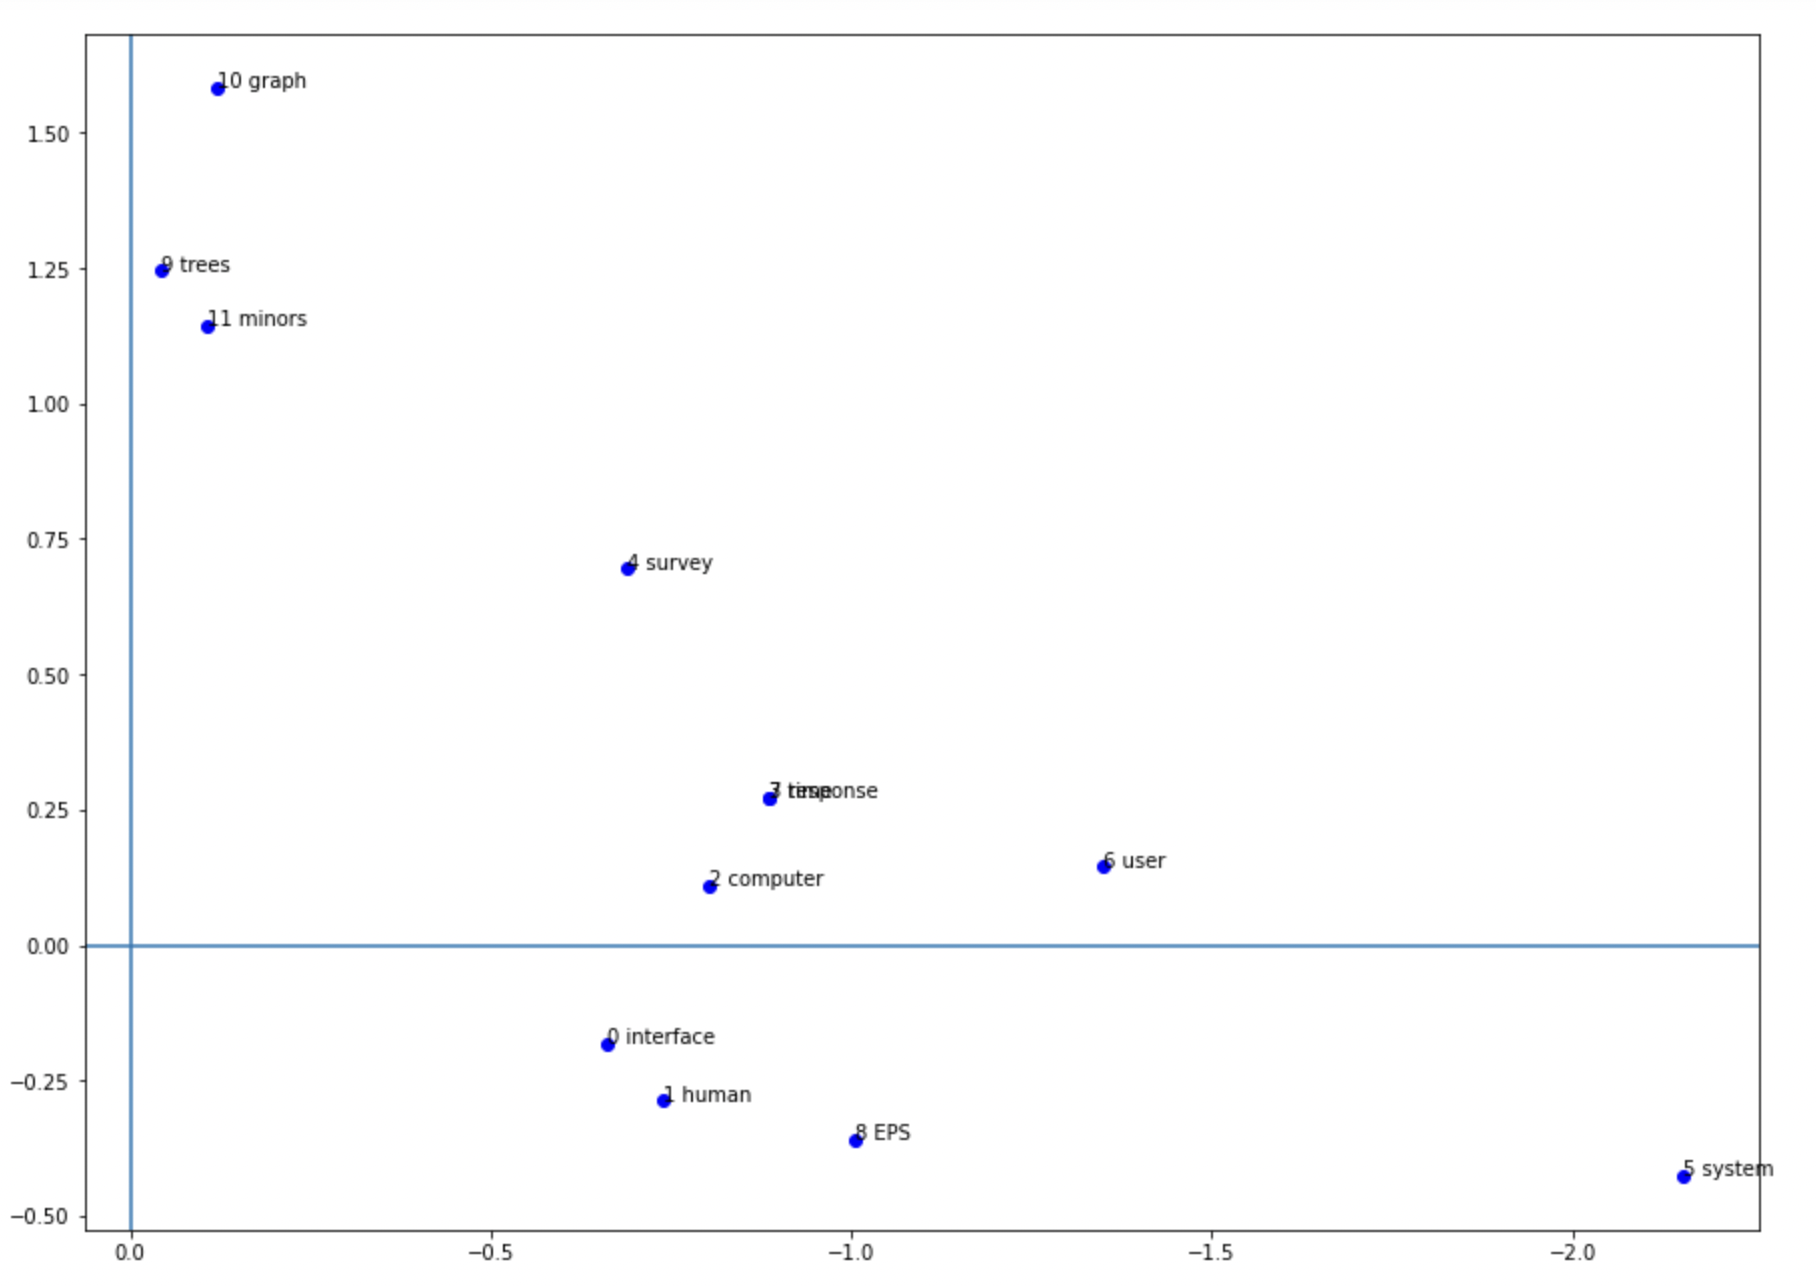

### Find matching documents for given document

In [ ]:
# Hint create query vector for input document. Calculate its cosine distance from other documents

def query(s, Uk, Sk, Vk_t, word_to_ix, documents, min_score=0.9):
    '''
    Input
        s:query document.
        Uk:Term matrix
        Sk:singular value matrix
        Vk_t:Document matrix
        word_to_ix: {word, index} map
        documents:list of document
        min_score:min score beyond which documents are considerd matching
    Output:
        q_hat: coordinates of query vector
        matches: list of tuples containing matching document and its score
    '''
    query_vector = build_td_matrix([s], word_to_ix)
    
    doc_transpose = np.transpose(Vk_t)

    query_vector_transpose = np.transpose(query_vector)
    q_hat = np.dot(query_vector_transpose, Uk)
    
    matches = []
    for i in range(len(documents)):
      score = (np.matmul(np.matmul(Sk,doc_transpose[:,i]),np.transpose(q_hat))/(np.linalg.norm(np.matmul(Sk,doc_transpose[:,i]))*np.linalg.norm(q_hat)))
      if score >= min_score:
        matches.append((documents[i], score[0]))

    return q_hat, matches

In [ ]:
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[[-0.53957337 -0.09974155]]
[('Human machine interface for Lab ABC computer applications', 0.9995096951268309), ('A survey of user opinion of computer system response time', 0.9780455918311483), ('The EPS user interface management system', 0.9999897752379737), ('System and human system engineering testing of EPS', 0.9989690972141732), ('Relation of user-perceived response time to error measurement', 0.9735754132851094)]


##### Expected
```CPP
[-0.461821   -0.07002767]
[('The EPS user interface management system', 0.9984452813340272), ('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('System and human system engineering testing of EPS', 0.9865886405556598), ('A survey of user opinion of computer system response time', 0.9374863669686595), ('Relation of user-perceived response time to error measurement', 0.9075594362644345)]
```

### Visual representation of query/document

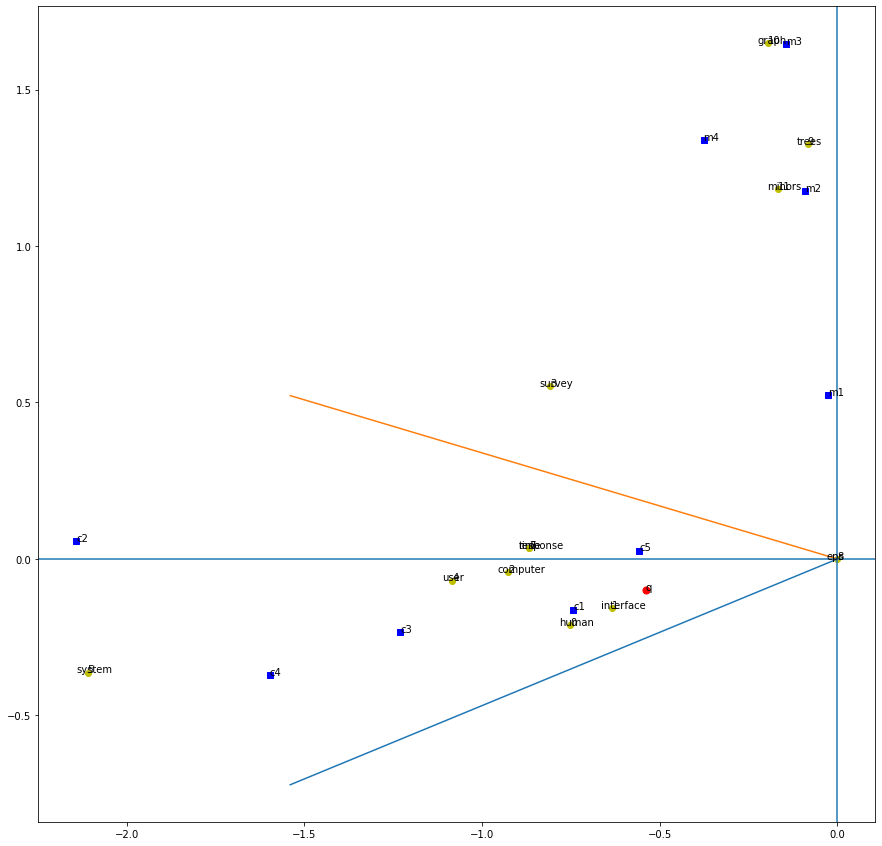

In [ ]:
# Plot terms, documents and query documents along with lines representing its cosine angle 
term_1 = [0, 0]
term_2 = [-1 + q_hat[0][0], -1 * math.cos(.9) + q_hat[0][1] ]
term_3 = [-1 + q_hat[0][0], 1 * math.cos(.9) + q_hat[0][1]]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot()
ax.scatter(x, y, c='b', marker="s")
ax.scatter(x1,y1, c='y', marker="o")
ax.scatter(q_hat[0][0],q_hat[0][1], s=50, c='r', marker="o")
ax.plot([term_1[0], term_2[0]], [term_1[1], term_2[1]])
ax.plot([term_1[0], term_3[0]], [term_1[1], term_3[1]])

for i in range(len(x1)):
    plt.annotate(terms[i], (x1[i] - 0.03, y1[i]))
    plt.annotate(index[i], (x1[i], y1[i]))
for i in range(len(x)):
    plt.annotate(docName[i], (x[i], y[i]))

plt.annotate('q', (q_hat[0][0],q_hat[0][1]))

plt.axhline(y=0)
plt.axvline(x=0)
plt.show()

##### Expected

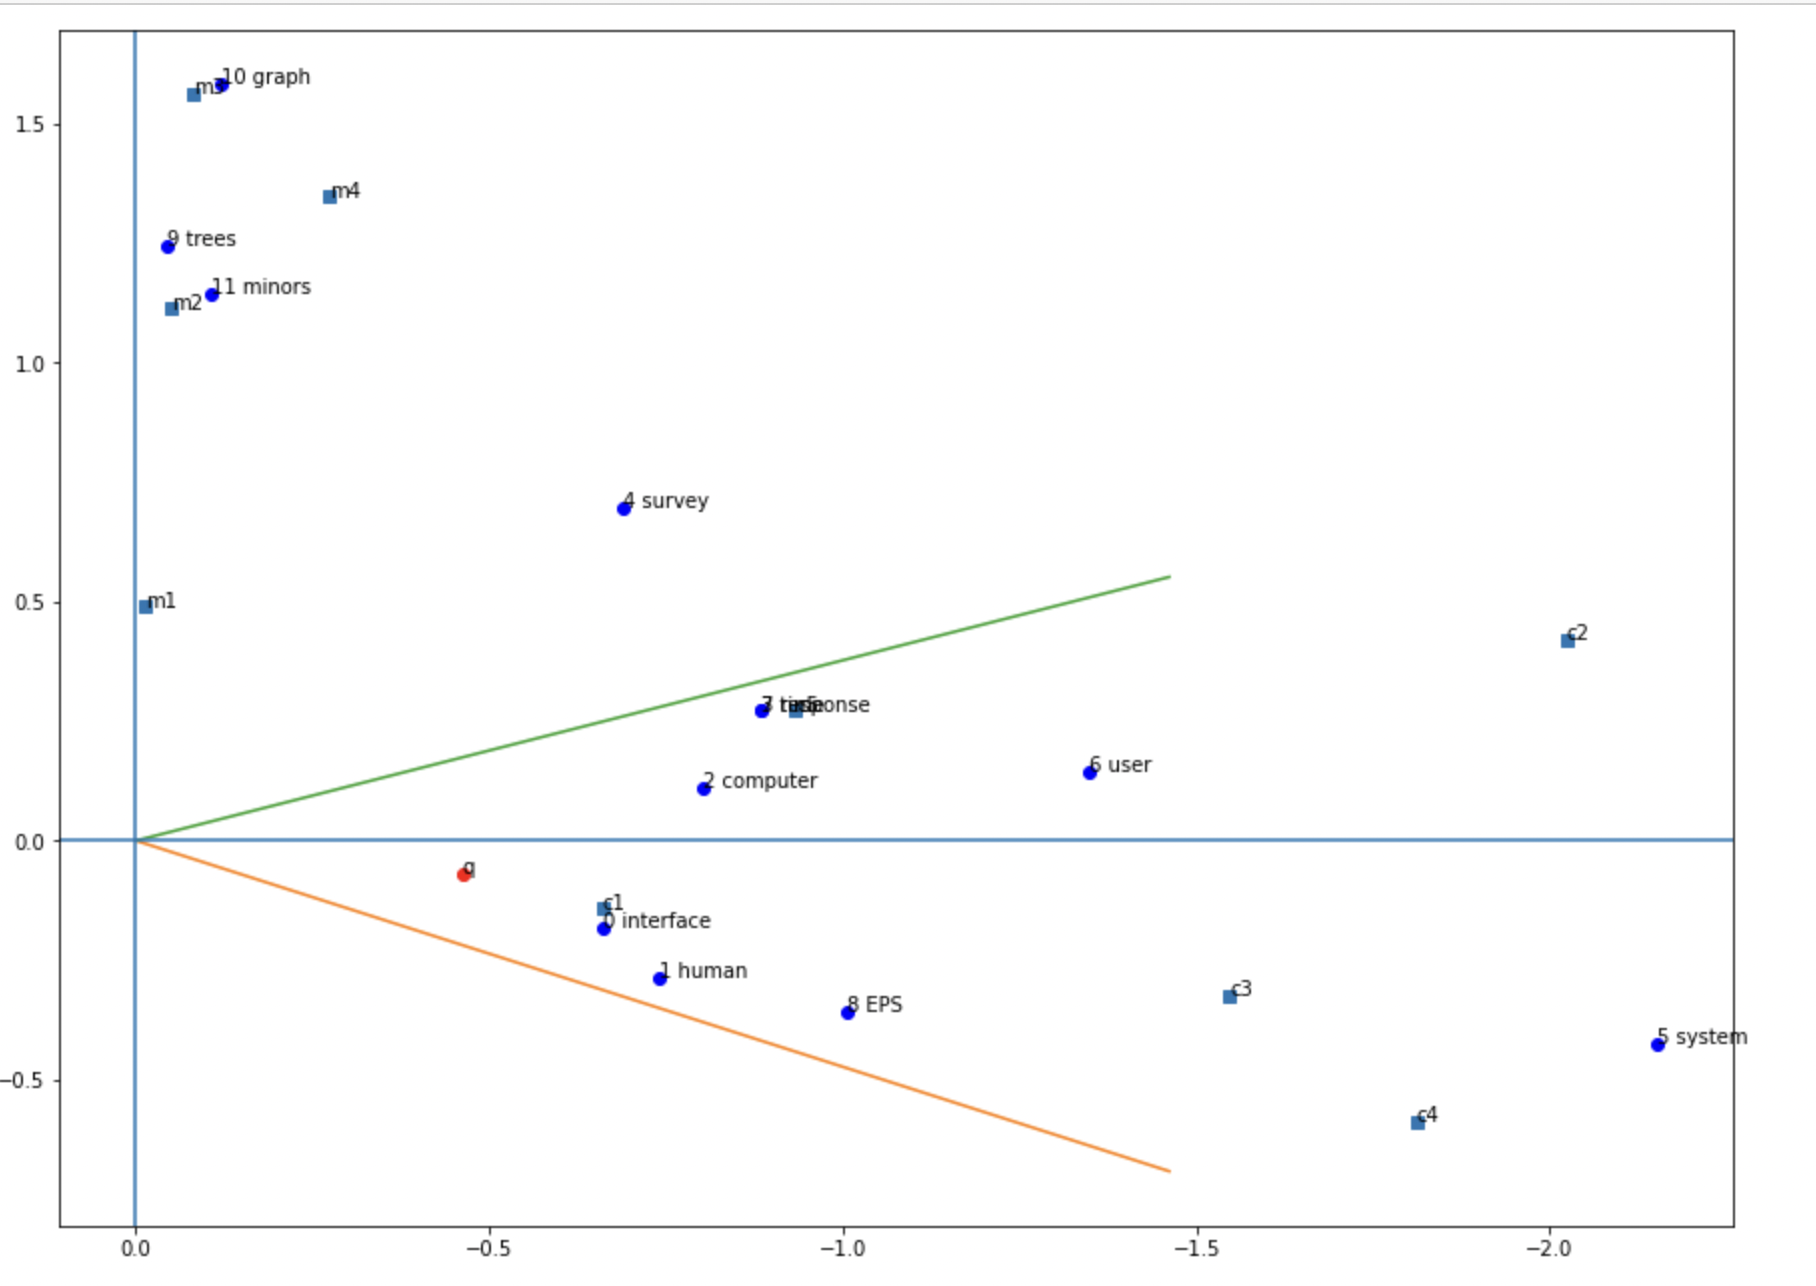


## Theory questions answered:
- A) Give short description of Left-eigen vectors, right-eigen vectors and eigen-values matrix retured by Singular Value Decompostion of document-terms count matrix.
- B) Visually represent the document "Graph and tree generation" in 2D space along with words and documents as given in previous question.

Answer to Question A

Left Eigen Vectors represents the rank of each word in the vocabulary in a document matrix. It has the dimensions of n x r.
Right Eigen Vectors depicting the transpose of vector. It has the dimensions of r x d.
Eigen Values matrix has same dimensions as the document_terms count matrix and is a diagonal product of the singular vectors.



Answer to Question B

In [ ]:
q_hat, matches = query('Graph and tree generation', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[[-0.06301328  0.65217791]]
[('The generation of random, binary, unordered trees', 0.9989833023274185), ('The intersection graph of paths in trees', 0.9997987189863758), ('Graph minors IV: Widths of trees and well-quasi-ordering', 0.9999577389341109), ('Graph minors: A survey', 0.984206455151762)]


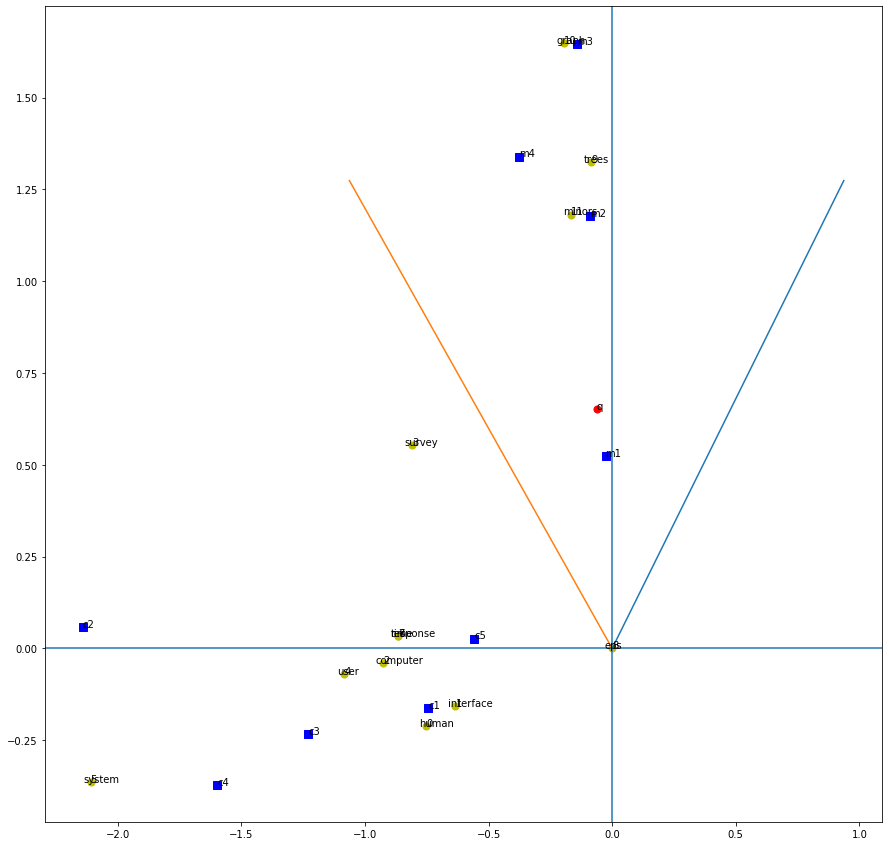

In [ ]:
term1 = [0, 0]
term2 = [1 + q_hat[0][0], 1 * math.cos(.9) + q_hat[0][1] ]
term3 = [-1 + q_hat[0][0], 1 * math.cos(.9) + q_hat[0][1]]

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot()
ax.scatter(x, y, s=50, c='b', marker="s")
ax.scatter(x1,y1, s=50, c='y', marker="o")
ax.scatter(q_hat[0][0],q_hat[0][1], s=50, c='r', marker="o")
ax.plot([term1[0], term2[0]], [term1[1], term2[1]])
ax.plot([term1[0], term3[0]], [term1[1], term3[1]])

for i in range(len(x1)):
    plt.annotate(terms[i], (x1[i] - 0.03, y1[i]))
    plt.annotate(index[i], (x1[i], y1[i]))
for i in range(len(x)):
    plt.annotate(docName[i], (x[i], y[i]))

plt.annotate('q', (q_hat[0][0],q_hat[0][1]))
plt.axhline(y=0)
plt.axvline(x=0)
plt.show()

# n-Gram Language Models

Our task is to train n-gram language models.

- Task 1: We will train unigram, bigram, and trigram models on given training files. Then we will score on given test files for unigram, bigram, and trigram. We will generate sentences from the trained model and compute perplexity.
- Task 2: we will create training data for n > 3, and repeat the above task from training model.

In [ ]:
'''
Your imports go here
You are encouraged to implement your own functions and not use from library.
'''
import sys
from collections import Counter
import numpy as np

In [ ]:
# constants to define pseudo-word tokens
# access via UNK, for instance
# for this assignemnt we will follow <s> tag for beginning of sentence and
# </s> for end of senetence as suggested in SLP Book. Check sample training files for reference.
UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"

We need to initialise global variables for model

In [ ]:

"""Initializes Parameters:
  n_gram (int): the n-gram order.
  is_laplace_smoothing (bool): whether or not to use Laplace smoothing
  threshold: words with frequency  below threshold will be converted to token
"""
# Initializing different object attributes
n_gram = 2
is_laplace_smoothing = True
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = {}
threshold = 1


### Implement training function 

In [ ]:
def make_ngrams(tokens: list, n: int) -> list:
    """Creates n-grams for the given token sequence.
    Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create

    Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
    """
    zipped = zip(*[tokens[i:] for i in range(0, n)])
    n_grams = [' '.join(ngram) for ngram in zipped]
    ## Your code here 
    return n_grams

In [ ]:
def train(training_file_path , n):   # Adding n as an argument to provide for different n-grams
    """
    Trains the language model on the given data. Input file that
    has tokens that are white-space separated, has one sentence per line, and
    that the sentences begin with <s> and end with </s>
    Parameters:
      training_file_path (str): the location of the training data to read

    Returns:
    N Gram Counts, Vocab, N Minus 1 Gram Counts
    """
    
    with open(training_file_path, 'r') as fh:
      content = fh.read().split() # Read and split data to get list of words
    
    # Get the count of each word
    word_count = {}
    for word in content:
      word_count[word] = word_count.get(word, 0) + 1

    # Replace the words with <UNK> if count is < threshold(=1)
    content = [a if word_count.get(a, 0) >= threshold else UNK for a in content]
    # make use of make_n_grams function
    n_gram_tokens = make_ngrams(content, n)
    n_gram_counts = {}
    for token in n_gram_tokens:
      n_gram_counts[token] = n_gram_counts.get(token, 0) + 1
    # Get the training data vocabulary
    vocab = np.unique(content)
    # For n>1 grams compute n-1 gram counts to compute probability
    n_minus_1_gram_counts = {}
    if n > 1:
      n_minus_1_gram_tokens = make_ngrams(content, n - 1)
      for token in n_minus_1_gram_tokens:
        n_minus_1_gram_counts[token] = n_minus_1_gram_counts.get(token, 0) + 1
    return n_gram_counts, vocab, n_minus_1_gram_counts

Output your Trained Data Parameters:

In [ ]:
uni_gram, uni_gram_vocab, uni_minus_1_gram = train("berp-training_uni.txt", 1)
bi_gram, bi_gram_vocab, bi_minus_1_gram = train("berp-training_bi.txt", 2)
tri_gram, tri_gram_vocab, tri_minus_1_gram = train("berp-training-tri.txt", 3)

In [ ]:
print(uni_gram)
print(uni_gram_vocab)

{'<s>': 6756, "let's": 236, 'start': 438, 'over': 414, '</s>': 6756, 'my': 36, 'mother': 2, 'is': 359, 'coming': 3, 'to': 2153, 'visit': 3, 'and': 261, "i'd": 508, 'like': 1221, 'take': 28, 'her': 1, 'dinner': 362, 'new': 4, 'query': 3, 'now': 49, "i'm": 246, 'interested': 42, 'in': 312, 'some': 323, 'middle': 17, 'eastern': 15, 'food': 992, 'oh': 51, 'i': 2264, 'have': 594, 'breakfast': 127, 'increase': 2, 'the': 937, 'walking': 56, 'distance': 165, 'can': 381, 'go': 390, 'fifteen': 110, 'minutes': 209, 'from': 205, 'icsi': 156, 'would': 652, 'french': 87, 'okay': 152, 'back': 23, 'normal': 3, 'stuff': 3, 'what': 235, 'about': 967, 'mexican': 92, 'uh': 431, 'how': 171, 'american': 129, 'or': 129, 'european': 20, 'prefer': 16, 'german': 62, 'preferably': 5, 'less': 154, 'than': 311, 'ten': 271, 'dollars': 576, 'something': 78, 'fattening': 1, 'blocks': 43, 'icksee': 95, "that's": 43, 'too': 51, 'far': 72, 'away': 59, 'money': 67, "doesn't": 113, 'matter': 137, 'restaurant': 599, 'shoul

In [ ]:
print(bi_gram)
print(bi_gram_vocab)

{"<s> let's": 196, "let's start": 170, 'start over': 403, 'over </s>': 367, '</s> <s>': 6755, '<s> my': 6, 'my mother': 2, 'mother is': 1, 'is coming': 1, 'coming to': 1, 'to visit': 2, 'visit and': 1, "and i'd": 5, "i'd like": 495, 'like to': 953, 'to take': 12, 'take her': 1, 'her to': 1, 'to dinner': 12, 'dinner </s>': 224, '<s> new': 1, 'new query': 1, 'query </s>': 2, '<s> now': 7, "now i'm": 8, "i'm interested": 35, 'interested in': 39, 'in some': 5, 'some middle': 5, 'middle eastern': 14, 'eastern food': 10, 'food </s>': 670, '<s> oh': 29, 'oh i': 11, 'i have': 91, 'have to': 17, 'to breakfast': 1, 'breakfast </s>': 89, 'i increase': 1, 'increase the': 2, 'the walking': 3, 'walking distance': 47, 'distance i': 3, 'i can': 69, 'can go': 14, 'go fifteen': 4, 'fifteen minutes': 28, 'minutes from': 50, 'from icsi': 95, 'icsi </s>': 127, 'i would': 607, 'would like': 585, 'to have': 280, 'have french': 4, 'french food': 28, '<s> okay': 126, 'okay back': 1, 'back to': 21, 'to the': 45

In [ ]:
print(tri_gram)
print(tri_gram_vocab)

{"<s> <s> let's": 196, "<s> let's start": 163, "let's start over": 136, 'start over </s>': 366, 'over </s> </s>': 367, '</s> </s> <s>': 6755, '</s> <s> <s>': 6755, '<s> <s> my': 6, '<s> my mother': 1, 'my mother is': 1, 'mother is coming': 1, 'is coming to': 1, 'coming to visit': 1, 'to visit and': 1, "visit and i'd": 1, "and i'd like": 5, "i'd like to": 409, 'like to take': 8, 'to take her': 1, 'take her to': 1, 'her to dinner': 1, 'to dinner </s>': 7, 'dinner </s> </s>': 224, '<s> <s> new': 1, '<s> new query': 1, 'new query </s>': 1, 'query </s> </s>': 2, '<s> <s> now': 7, "<s> now i'm": 3, "now i'm interested": 6, "i'm interested in": 33, 'interested in some': 2, 'in some middle': 1, 'some middle eastern': 5, 'middle eastern food': 10, 'eastern food </s>': 10, 'food </s> </s>': 670, '<s> <s> oh': 29, '<s> oh i': 9, 'oh i have': 1, 'i have to': 8, 'have to breakfast': 1, 'to breakfast </s>': 1, 'breakfast </s> </s>': 89, 'oh i increase': 1, 'i increase the': 1, 'increase the walking'

### Scoring function:
Implement Score function that will take input sentence and output probability of given string representing a single sentence.

In [ ]:
def score(sentence, n_gram_counts, vocab, n_minus_1_gram_counts, n):
    """Calculates the probability score for a given string representing a single sentence.
    Parameters:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
      
    Returns:
      float: the probability value of the given string for this model
    """
    # Split the input sentence and replace out of vocabulary tokens with <UNK>    
    
    tokens = sentence.split()
    probability = []
    
    for ind, word in enumerate(tokens):
        if word not in vocab:
            tokens[ind] = UNK
        if n == 1:
            probability.append(n_gram_counts.get(tokens[ind], 0)/sum(n_gram_counts.values()))
        else:
            if ind >= n - 1:
                c_n = n_gram_counts.get(" ".join(tokens[ind - n + 1 : ind + 1]), 0)
                c_d = n_minus_1_gram_counts.get(" ".join(tokens[ind - n + 1 : ind]), 0)
                probability.append((c_n + 1)/(c_d + len(vocab)))
        
    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability
    return np.prod(probability)

Uni-gram : Number of Sentences

In [ ]:
with open("berp-training_uni.txt", 'r') as fh:
    test_content_1 = fh.read().split("\n")
num_sentences_1 = len(test_content_1)
ten_sentences_1 = test_content_1[:10]
print("# of test sentences: ", num_sentences_1)
probablities_1 = []

# of test sentences:  6757


Bi-gram : Number of Sentences

In [ ]:
with open("berp-training_bi.txt", 'r') as fh:
    test_content_2 = fh.read().split("\n")
num_sentences_2 = len(test_content_2)
ten_sentences_2 = test_content_2[:10]
print("# of test sentences: ", num_sentences_2)
probablities_2 = []

# of test sentences:  6757


Tri-gram : Number of Sentences

In [ ]:
with open("berp-training-tri.txt", 'r') as fh:
    test_content_3 = fh.read().split("\n")
num_sentences_3 = len(test_content_3)
ten_sentences_3 = test_content_3[:10]
print("# of test sentences: ", num_sentences_3)
probablities_3 = []

# of test sentences:  6757


Uni-gram : Probabilities

In [ ]:
# print probabilities/score of sentences in test content
for sentence in test_content_1:
  probablities_1.append(score(sentence, uni_gram, uni_gram_vocab, uni_minus_1_gram, 1))
probablities_1 = np.array(probablities_1)
mean_1 = np.mean(probablities_1)
std_dev_1 = np.std(probablities_1)
print(mean_1)
print(std_dev_1)

8.333161665313633e-05
0.008602284188167832


Bi-gram : Probabilities

In [ ]:
for sentence in test_content_2:
  probablities_2.append(score(sentence, bi_gram, bi_gram_vocab, bi_minus_1_gram, 2))
probablities_2 = np.array(probablities_2)
mean_2 = np.mean(probablities_2)
std_dev_2 = np.std(probablities_2)
print(mean_2)
print(std_dev_2)

0.00020028031078202113
0.012166162987460196


Tri-gram : Probabilities

In [ ]:
for sentence in test_content_3:
  probablities_3.append(score(sentence, tri_gram, tri_gram_vocab, tri_minus_1_gram, 3))
probablities_3 = np.array(probablities_3)
mean_3 = np.mean(probablities_3)
std_dev_3 = np.std(probablities_3)
print(mean_3)
print(std_dev_3)

0.00015425672639572435
0.012164371990996103


### Sentence generation
Generate sentence from the above trained model
- To generate next word from a set of probable n-grams and their probabilities check below tutorial:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [ ]:
def prob_unigram(vocab, n_gram_counts, n_minus_1_gram_counts):
    prob = []
    for word in vocab:
        prob.append(n_gram_counts.get(word)/sum(n_gram_counts.values()))
    return prob

Other code

In [ ]:
def get_unigram_prob(vocab, n_gram_counts, n_minus_1_gram_counts):
    prob = []
    for word in vocab:
        prob.append(n_gram_counts.get(word)/sum(n_gram_counts.values()))
    return prob

In [ ]:
def generate_sentence(prob, n, vocab,  n_gram_counts, n_minus_1_gram_counts):
    """Generates a single sentence from a trained language model using the Shannon technique.
      
    Returns:
      str: the generated sentence
    """
    # Start with <s> and randomly generate words until we encounter sentence end
    # Append sentence begin markers for n>2
    # Keep track of previous word for stop condition
    
    prev_word = ''
    if n > 1:
        words = np.random.choice(list(n_minus_1_gram_counts.keys()), 1)[0].split()
        probability = {}
        while prev_word != "</s>":
            max_prob_dict = {}
            for grams in n_gram_counts.keys():
                bi = grams.split()
                if [" ".join(bi[0 : n-1])] == [" ".join(words[len(words) - n + 1:])]:
                    #max_prob_dict[grams] = n_gram_counts.get(grams)
                    probability[bi[n - 1]] = n_gram_counts.get(grams)/n_minus_1_gram_counts.get(" ".join(bi[0 : n-1]))
            #max_w = max(max_prob_dict, key = max_prob_dict.get).split()
            max_w = np.random.choice(list(probability.keys()), 1, probability.values)[0]
            words.append(max_w)
            prev_word = max_w
            
        # Construct the (n-1) gram so far
        # Get the counts of all available choices based on n-1 gram
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word
    else:
      # In case of unigram model, n-1 gram is just the previous word and possible choice is whole vocabulary
        words = []
        while prev_word != "</s>":
            prev_word = np.random.choice(vocab, 1, prob)[0]
            words.append(prev_word)
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word
    sentence = [' '.join(words)]
    return sentence

In [ ]:
def generate(n, n_gram, n_gram_counts, vocab, n_minus_1_gram_counts):
    """Generates n sentences from a trained language model using the Shannon technique.
    Parameters:
      n (int): the number of sentences to generate
      
    Returns:
      list: a list containing strings, one per generated sentence
    """
    sentences = []
    for i in range(0, n):
        if n_gram == 1:
            sentences.append(generate_sentence(get_unigram_prob(vocab,  n_gram_counts, n_minus_1_gram_counts), n_gram, vocab,  n_gram_counts, n_minus_1_gram_counts))
        else:
            sentences.append(generate_sentence({}, n_gram, vocab,  n_gram_counts, n_minus_1_gram_counts))
    
    # Generate sentences one by one and store
    return sentences

End


Generating Sentences for Uni-gram

In [ ]:
sentences = generate(50, 1, uni_gram, uni_gram_vocab, uni_minus_1_gram)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Sentences:
["eastern interested eighty weather quality sit med cha-am spot shop weekend sounds surrounding no joshu-ya reasonable mall listen spending where rest giovanni thousand szechuan cooking jewish bagel szechuan prepared bistro a pork arinell pavilion unimportant i'll nicest further selects cafes now restoran-rasa-sayang tasty green weekends special student viva african screen south salads blocks lunch carne most out let's cuisine amount three sweet venezia's blue takeout somewhere take iranian amaru both date let's kirala waitresses weeknights drive spoon being bakeries crash belly sushi-sho milvia spicy recommend item in burmese tambo since mood complete lots dollars roll cafe milvia they're distant helpful print bette's it's thirteen point steak list somewhere malts smoke make clear midweek wanted lo-cal say boiled billion favorite shops sixteen nakapan where's quarter foods arinell unless done does days these hearst cha-am eiffel's hopefully personal lococo's slow displaying

Generating Sentences for Bi-gram

In [ ]:
sentences = generate(50, 2, bi_gram, bi_gram_vocab, bi_minus_1_gram)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Sentences:
["fish and wine wouldn't bagel of expensive vietnamese place berkeley session cheap some inexpensive should uh tonight how day fifteen than vegi in caffe vegetarian traveling information your south how brunch available i'd burgers hamburgers kind has if after eating le sort dining four nine favorite town or anytime portuguese excellent dinner thai fruits may does grill or albany european how sunday korean wine ann's africa american than it's well she hang have three fifty addition two give sushi next drinks kilometers saturdays grill inexpensive meal arabian under monday spicy lococo's vegi kind because like four vegi milkshakes yesterday spicy just upscale college coffee hong-kong salad up town ice i've sujatha's berkeley um log and grill time hungarian recognized eating something driving duck miles medium very jupiter dishes maharani jones sun-hong-kong look nice concerned french doesn't peruvian or solano cut serving than what's duck berkeley make soup also mid-price fren

Generating Sentences for Tri-gram

In [ ]:
sentences = generate(50, 3, tri_gram, tri_gram_vocab, tri_minus_1_gram)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Sentences:
['distance you like oriental oriental </s>']
['any directions </s>']
["two dollars and per i'm i'm </s>"]
["said i would a very pay pay don't quick prosperous spend prefer prosperous like cheap don't also not pay prosperous prefer quick prosperous expensive invite quick don't wanted say prosperous like say pay prefer want don't wanted a don't cheap very prosperous prefer cheap guest spend walk would very hamburger prosperous pay very spend cheap much eat much quick a go walk don't sandwich walk don't chinese hamburger guest expensive spend invite prosperous don't very eat prosperous chinese a chinese much cheap cheap pay place place want chinese expensive also go food a chinese hamburger chinese also say </s>"]
["serve vegetarian food at is please cafe santa-fe food and yoshi's friday pasand and the very it's burritos go type not cost burritos it cafe more cafe meal um the juan's any yoshi's go go at um friday somewhere restaurant no burritos more the santa-fe cost the i'm m

### Evaluate model perplexity:
Measures the perplexity for the test sequence with your trained model. 
you may assume that this sequence may consist of many sentences "glued together"

The perplexity of the given sequence is the inverse probability of the test set, normalized by the number of words.


In [ ]:
# Since this sequence will cross many sentence boundaries, we need to include 
# the begin- and end-sentence markers <s> and </s> in the probability computation. 
# We also need to include the end-of-sentence marker </s> 
# but not the beginning-of-sentence marker <s>) in the total count of word tokens N

def perplexity(test_sequence, n, n_gram_counts, vocab, n_minus_1_gram_counts):
    """.
    Parameters:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity of

    Returns:
      float: the perplexity of the given sequence
    """ 

    # Replace out of vocab words with <UNK>, already done in score function
    test_sequence = [token if token in vocab else UNK for token in test_sequence.split()]



    # Remove sentence begin markers from data for computing N
    compute_n = [word for word in test_sequence if word != '<s>']
    
    N = len(compute_n)
    # Get the probability for the sequence
    probability = []
        
    for ind, word in enumerate(test_sequence):
        if n == 1:
            probability.append(n_gram_counts.get(word, 0)/sum(n_gram_counts.values()))
        else:
            if ind >= n - 1:
                c_n = n_gram_counts.get(" ".join(test_sequence[ind - n + 1 : ind + 1]), 0)
                c_d = n_minus_1_gram_counts.get(" ".join(test_sequence[ind - n + 1 : ind]), 0)
                probability.append((c_n + 1)/(c_d + len(vocab)))
    
    perplexity = pow(np.prod(probability), -1/N)
    return perplexity

Uni-gram Perplexity

In [ ]:
with open("hw2-test_uni.txt", 'r') as fh:
    test_content = fh.read().split("\n")

print(perplexity(" ".join(test_content[0:10]), 1, uni_gram, uni_gram_vocab, uni_minus_1_gram))

inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
with open("hw2-test_bi.txt", 'r') as fh:
    test_content = fh.read().split("\n")

print(perplexity(" ".join(test_content[0:10]), 2, bi_gram, bi_gram_vocab, bi_minus_1_gram))

120.53801778097124


In [ ]:
with open("hw2-test-tri.txt", 'r') as fh:
    test_content = fh.read().split("\n")

print(perplexity(" ".join(test_content[0:10]), 2, tri_gram, tri_gram_vocab, tri_minus_1_gram))

8175.090275956457


### **Explore and explain: **
* Experiment n_gram model for n = [1,2,3..7] of your choice. Explain the best choice of n that generates more meaninful sentences.


In [ ]:
four_gram, four_gram_vocab, four_minus_1_gram = train("berp-training-four.txt", 4)
five_gram, five_gram_vocab, five_minus_1_gram = train("berp-training-five.txt", 5)
six_gram, six_gram_vocab, six_minus_1_gram = train("berp-training-six.txt", 6)
seven_gram, seven_gram_vocab, seven_minus_1_gram = train("berp-training-seven.txt", 7)

Four-gram

In [ ]:
with open("hw2-test-four.txt", 'r') as fh:
    test_content_4 = fh.read().split("\n")
num_sentences_4 = len(test_content_4)
ten_sentences_4 = test_content_1[:10]
print("# of test sentences: ", num_sentences_4)
probablities_4 = []
for sentence in test_content_4:
  probablities_4.append(score(sentence, four_gram, four_gram_vocab, four_minus_1_gram, 4))
probablities_4 = np.array(probablities_4)
mean_4 = np.mean(probablities_4)
std_dev_4 = np.std(probablities_4)
print(mean_4)
print(std_dev_4)

# of test sentences:  100
2.729396759917997e-07
2.4898710639051558e-06


Five-gram

In [ ]:
with open("hw2-test_five.txt", 'r') as fh:
    test_content_5 = fh.read().split("\n")
num_sentences_5 = len(test_content_5)
ten_sentences_5 = test_content_5[:10]
print("# of test sentences: ", num_sentences_5)
probablities_5 = []
for sentence in test_content_5:
  probablities_5.append(score(sentence, five_gram, five_gram_vocab, five_minus_1_gram, 5))
probablities_5 = np.array(probablities_5)
mean_5 = np.mean(probablities_5)
std_dev_5 = np.std(probablities_5)
print(mean_5)
print(std_dev_5)

# of test sentences:  100
3.579933296244941e-08
3.421348220869913e-07


Six-Gram

In [ ]:
with open("hw2-test_six.txt", 'r') as fh:
    test_content_6 = fh.read().split("\n")
num_sentences_6 = len(test_content_6)
ten_sentences_6 = test_content_6[:10]
print("# of test sentences: ", num_sentences_6)
probablities_6 = []
for sentence in test_content_6:
  probablities_6.append(score(sentence, six_gram, six_gram_vocab, six_minus_1_gram, 6))
probablities_6 = np.array(probablities_6)
mean_6 = np.mean(probablities_6)
std_dev_6 = np.std(probablities_6)
print(mean_6)
print(std_dev_6)

# of test sentences:  100
4.828450679999185e-09
4.703766311984171e-08


Seven-Gram

In [ ]:
with open("hw2-test_seven.txt", 'r') as fh:
    test_content_7 = fh.read().split("\n")
num_sentences_7 = len(test_content_7)
ten_sentences_7 = test_content_7[:10]
print("# of test sentences: ", num_sentences_7)
probablities_7 = []
for sentence in test_content_7:
  probablities_7.append(score(sentence, seven_gram, seven_gram_vocab, seven_minus_1_gram, 7))
probablities_7 = np.array(probablities_7)
mean_7 = np.mean(probablities_7)
std_dev_7 = np.std(probablities_7)
print(mean_7)
print(std_dev_7)

# of test sentences:  100
6.576808561597617e-10
6.46715047279205e-09


Four-Gram Sentence Generation

In [ ]:
sentences = generate(50, 4, four_gram, four_gram_vocab, four_minus_1_gram)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Sentences:
['parents when they come into come town town into town into into come town into into into into town town come come town town town town come come into into into come town town town come come come into town into town come town into into town town um town into um into town um come italian um town town come um into into into italian um come into come come come town um come come italian um come into um into italian town town into um town town into um italian italian um um into town into um into italian um um into um come um come italian come come come italian italian come come into into italian um town um town into um come italian italian um come come italian town um come um um um into come into town town town into italian into come into town um italian town town town um italian town um come come into italian food town come um into town come come come come food into into um food um italian into food um italian into come come town come town food into town into italian town town co

Five-Gram Sentence Generation

In [ ]:
sentences = generate(50, 5, five_gram, five_gram_vocab, five_minus_1_gram)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Six-Gram Sentence Generation

In [ ]:
sentences = generate(50, 6, six_gram, six_gram_vocab, six_minus_1_gram)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Seven-Gram Sentence Generation

In [ ]:
sentences = generate(50, 7, seven_gram, seven_gram_vocab, seven_minus_1_gram)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Four-Gram Perplexity

In [ ]:
with open("hw2-test-four.txt", 'r') as fh:
    test_content = fh.read().split("\n")

print(perplexity(" ".join(test_content[0:10]), 4, four_gram, four_gram_vocab, four_minus_1_gram))

334.5478955821294


Five-Gram Perplexity

In [ ]:
with open("hw2-test_five.txt", 'r') as fh:
    test_content = fh.read().split("\n")

print(perplexity(" ".join(test_content[0:10]), 5, five_gram, five_gram_vocab, five_minus_1_gram))

409.0388251035709


Six-Gram Perplexity

In [ ]:
with open("hw2-test_six.txt", 'r') as fh:
    test_content = fh.read().split("\n")

print(perplexity(" ".join(test_content[0:10]), 6, six_gram, six_gram_vocab, six_minus_1_gram))

469.0551996296463


Seven-Gram Perplexity

In [ ]:
with open("hw2-test_seven.txt", 'r') as fh:
    test_content = fh.read().split("\n")

print(perplexity(" ".join(test_content[0:10]), 7, seven_gram, seven_gram_vocab, seven_minus_1_gram))

521.4246959014555


Theory Answer:

Since the Perplexity is the lowest with Bi-gram generated sentences, it would be the best option to generate sentences. Followed by four-gram with the next lowest perplexity, would also be suitable to generate sentences.

# Classification using LSTM - using Tensorflow
In this part, we will be building a bidirectional LSTM network to train and inference sentiment analysis on IMDB dataset.<br>

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time to tweak your hyperparameters.
- Without a GPU, You might have to wait longer to experiment.

### Library Imports

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



### Visualizing data distribution




In [ ]:
## Reading the data and removing columns that are not important. 
dataset = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [ ]:
 #######################################################   
 # print head of data frame with help of head function # 
 #######################################################
 
dataset.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Petter Mattei's "Love in the Time of Money" is...  positive
4  Probably my all-time favorite movie, a story o...  positive

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


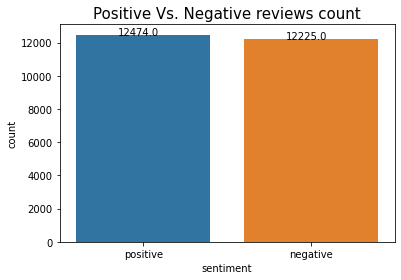

In [ ]:
 ####################################################### 
 # plot Positive Vs. Negative reviews count            # 
 #######################################################

ax = sns.countplot(dataset['sentiment'])
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()



### Cleaning the Reviews

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
 #############################################################################################  
 # Clean all the reviews in the dataset using the clean_text function provided above         # 
 ############################################################################################# 
clean_reviews = []
for text in dataset['review']:
     clean_reviews.append(clean_text(text))


In [ ]:
dataset['review'] = pd.DataFrame(clean_reviews)

In [ ]:
 #####################################################################
 # print head of the "CLEANED" data frame with help of head function # 
 #####################################################################
 dataset.head()


review sentiment
0  one reviewer mentioned watching 1 oz episode y...  positive
1  wonderful little production br br filming tech...  positive
2  thought wonderful way spend time hot summer we...  positive
3  petter matteis love time money visually stunni...  positive
4  probably alltime favorite movie story selfless...  positive

### Splitting the dataset and Encoding Labels

Spliting data: <br> 
80% for the training and the remaining 20% for validation.

Encoding Labels: <br>
Encode labels as negative and positive as 0 and 1 respectively


In [ ]:
#################################################################################
# Split the data using the sklearn module                                       #
# 80% for the training and the remaining 20% for validation                     #
#################################################################################
X = dataset['review']
y = dataset['sentiment']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)


In [ ]:
#################################################################################
# Initialize label encoder from sklearn module                                  #
# fit on train labels and transform both train and validation labels            #
#################################################################################
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)


### Pre-Processing The Text
 

In [ ]:
# You can use the modules given below
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

###############################################################################  
# Fit your tokenizer on the training reviews                                  #
###############################################################################
tokenizer = Tokenizer(split = ' ')
tokenizer.fit_on_texts(X_train)


#################################################################################################
# The word_index dictionary assigns a unique index to each unique word present in the training  #
# reviews.                                                                                      #
#                                                                                               #
# Create the word_index dictionary using the tokenizer                                          #
# Find the vocabulary of your training reviews                                                 #
################################################## ###############################################

word_index = tokenizer.word_index
vocabulary = list(word_index.keys())




#################################################################################################
# Convert the reviews in the dataset to their index form by using a function available          #
# with the tokenizer                                                                            #
# HINT : convert training and validation reviews into sequences                                 #
#################################################################################################
train_sequences = tokenizer.texts_to_sequences(X_train)
validation_sequences = tokenizer.texts_to_sequences(X_val)

print("The document count",tokenizer.document_count)


#################################################################################################
# Pad the the training and validation sequences so all of them have the same length             # 
# set maxlen = 200                                                                              #
#################################################################################################
train_padded = pad_sequences(train_sequences, maxlen=200)
val_padded = pad_sequences(validation_sequences, maxlen=200)
# maxlen which is the maximum length of one review we will use for our training

print('Vocabulary : {}'.format(vocabulary))

The document count 19759
Vocabulary : ['br', 'movie', 'film', 'one', 'like', 'time', 'good', 'character', 'get', 'even', 'would', 'story', 'make', 'see', 'really', 'scene', 'well', 'much', 'people', 'also', 'great', 'bad', 'dont', 'first', 'show', 'way', 'thing', 'made', 'could', 'think', 'go', 'life', 'know', 'watch', 'many', 'love', 'actor', 'seen', 'never', 'two', 'plot', 'say', 'acting', 'best', 'look', 'little', 'end', 'year', 'ever', 'take', 'come', 'still', 'better', 'man', 'work', 'something', 'find', 'part', 'give', 'lot', 'im', 'want', 'director', 'back', 'real', 'guy', 'performance', 'watching', 'play', 'woman', 'doesnt', 'didnt', 'though', 'actually', 'another', 'funny', 'nothing', 'u', 'every', 'new', 'going', 'role', 'old', 'thats', 'girl', 'point', 'pretty', 'quite', 'feel', 'cant', 'day', 'world', 'cast', 'seems', 'fact', 'minute', 'young', 'thought', 'however', 'comedy', 'around', 'horror', 'got', 'enough', 'action', 'may', 'right', 'bit', 'big', 'without', 'friend', '

### Using glove vectors for embedding

GloVe vectors capture both global statistics and local statistics of a corpus. We use GloVe to convert words to embeddings in the vector space based on their semantics. 

We will be using the 200-dimensional GloVe vectors for the task at hand.

To learn more about GloVe please read the following resource:
- https://nlp.stanford.edu/pubs/glove.pdf

In [ ]:
glove_dictionary = {}
with open('glove.6B.200d.txt') as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [ ]:
 # All the words which are not in the GloVe dictionary will be assigned a zero vector.

embedding_matrix = np.zeros((len(vocabulary)+1, 200))

######################################################################
# The glove_dictionary contains words vs their respective embeddings #
#                                                                    #
# Create the embedding matrix using the glove_dictionary             #
######################################################################
for word, i in word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [ ]:
embedding_matrix.shape

(99847, 200)

Sample output : (99987, 200)

### Creating The Model (10)

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time.
- Without a GPU, You might have to wait longer to experiment.


Useful resources : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout <br>





In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

tf.random.set_seed(42)

######################################################
# Complete this linear model in tensorflow           #
######################################################

def build_model(embedding_matrix):

  ''' 
  Arguments:
    embedding_matrix : a matrix with the corresponding embeddings
    of all words.

  Returns:
    The LSTM model that you created.
  '''
  
  model = tf.keras.Sequential()


  # TO DO: layer 1 : add embedding layer
  # The embedding layer maps the words to their embedding vectors from the embedding matrix
  embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=200,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False)   
  model.add(embedding_layer)
  model.add(tf.keras.layers.Dropout(rate = 0.4))
  # TO DO: layer 2 : add Bidirectional LSTM Layer 
  model.add(Bidirectional(LSTM(64, return_sequences=True)))
  model.add(tf.keras.layers.Dropout(rate = 0.4))

  # TO DO Add more layers : you can add more dense layers and dropout
  # NOTE : You should be able to achieve an validation accuracy greater than 85%
  #        within 10 epochs
  #model.add(Dense(2048, activation='relu'))
  model.add(Bidirectional(LSTM(64)))
  model.add(tf.keras.layers.Dropout(rate = 0.4))
  

  # TO DO Final layer : add output layer and activation 
  model.add(Dense(1, activation='sigmoid'))

  # TO DO : use a loss function, optimizer as adam to compile 
  # and evaluate model on auc,precision,recall,accuracy
  # HINT : choose your loss function based on the task (binary classification)
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['AUC' , 'accuracy' , 'Precision' , 'Recall'])
  return model

In [ ]:
# NOTE : You should be able to achieve an validation accuracy greater than 85%
#        within 10 epochs

#################################################################
# Call the build_model function and initialize the model        #
#################################################################
num_epochs = 10
history = build_model(embedding_matrix).fit(train_padded, y_train, validation_data = (val_padded,y_val), epochs = num_epochs)
#######################################################################################################
# train and validate the model on the padded sequences of text which we have created initially        #
#######################################################################################################


Epoch 1/10
618/618 [==============================] - 194s 304ms/step - loss: 0.4821 - auc: 0.8498 - accuracy: 0.7736 - precision: 0.7742 - recall: 0.7823 - val_loss: 0.3808 - val_auc: 0.9110 - val_accuracy: 0.8338 - val_precision: 0.8226 - val_recall: 0.8459
Epoch 2/10
618/618 [==============================] - 192s 310ms/step - loss: 0.3684 - auc: 0.9160 - accuracy: 0.8384 - precision: 0.8407 - recall: 0.8411 - val_loss: 0.3429 - val_auc: 0.9293 - val_accuracy: 0.8524 - val_precision: 0.8636 - val_recall: 0.8328
Epoch 3/10
618/618 [==============================] - 179s 290ms/step - loss: 0.3088 - auc: 0.9415 - accuracy: 0.8678 - precision: 0.8665 - recall: 0.8743 - val_loss: 0.3378 - val_auc: 0.9376 - val_accuracy: 0.8522 - val_precision: 0.8114 - val_recall: 0.9131
Epoch 4/10
618/618 [==============================] - 190s 307ms/step - loss: 0.2629 - auc: 0.9576 - accuracy: 0.8921 - precision: 0.8880 - recall: 0.9011 - val_loss: 0.3399 - val_auc: 0.9358 - val_accuracy: 0.8508 - val

### Plotting Accuracy and Losses (5 Points)
 




In [ ]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################



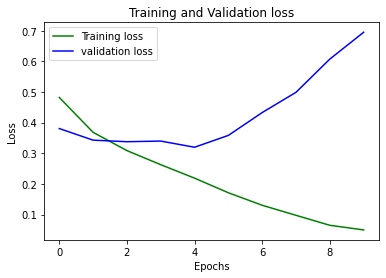

In [ ]:
#Train loss vs Val loss
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,10)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

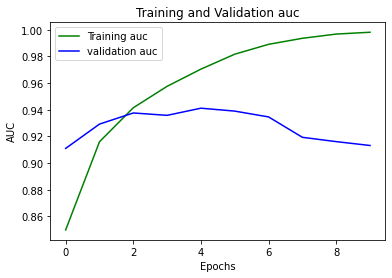

In [ ]:
#Train auc vs Val auc
auc_train = history.history['auc']
auc_val = history.history['val_auc']
epochs = range(0,10)
plt.plot(epochs, auc_train, 'g', label='Training auc')
plt.plot(epochs, auc_val, 'b', label='validation auc')
plt.title('Training and Validation auc')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

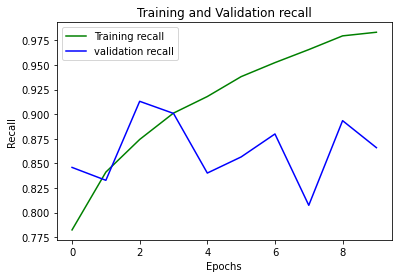

In [ ]:
#Train recall vs Val recall
recall_train = history.history['recall']
recall_val = history.history['val_recall']
epochs = range(0,10)
plt.plot(epochs, recall_train, 'g', label='Training recall')
plt.plot(epochs, recall_val, 'b', label='validation recall')
plt.title('Training and Validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

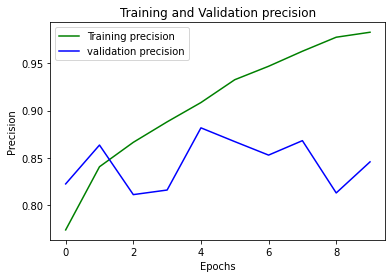

In [ ]:
#Train precision vs Val precision
precision_train = history.history['precision']
precision_val = history.history['val_precision']
epochs = range(0,10)
plt.plot(epochs, precision_train, 'g', label='Training precision')
plt.plot(epochs, precision_val, 'b', label='validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.show()

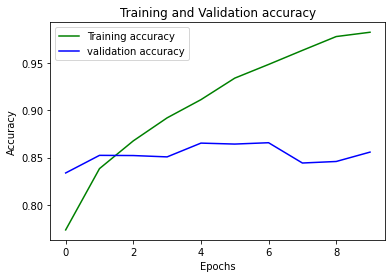

In [ ]:
#Train accuracy vs Val accuracy
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(0,10)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# You will need to include the pickled model along with the other submission files
# The saved model will be used to verify your lstm's predictions on hidden reviews

##################################################################################
# Save your trained model as a pickle file named "lstm_classifier"               #
# You will be using this saved model to make predictions in the next module      #
##################################################################################

import pickle 
filename = 'lstm_classifier.sav'
pickle.dump(build_model(embedding_matrix), open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://67c477d7-968d-4428-af54-adb035ce04be/assets


INFO:tensorflow:Assets written to: ram://67c477d7-968d-4428-af54-adb035ce04be/assets


### Prediction (5 Points)

In [ ]:
######################################################################
# Load your saved model                                              #
# Use the saved model to make predictions                            #
######################################################################
filename = 'lstm_classifier.sav'
saved_model = pickle.load(open(filename, 'rb'))

In [ ]:
# use the saved model to predict the reviews
def predict_review(review):
    clean_review = clean_text(review)
    review_sequences = tokenizer.texts_to_sequences([clean_review])
    review_padded = pad_sequences(review_sequences, maxlen = 200)
    prediction = saved_model.predict(review_padded)
    if prediction>0.5:
        return 1
    else:
        return 0
'''
  Arguments:
    review : A single review for which you want to predict the sentiment for.
             example: "This movie was amazing! I would defenitely watch it again."

  Returns:
    The predicted sentiment for the review : either 1 or 0
'''

 ############################################################################# 
 # Predict the sentiment for the given review using the model                #
 # that you trained and return the sentiment                                 #
 #                                                                           #
 # HINT : Remember that the review needs to be "preprocessed" before you use #
 # it for prediction                                                         #
 #############################################################################

pass



In [ ]:
# Do not edit this cell

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = predict_review(review)
    print(f'{review[:100]} -> {p}')
    

### Expected Output:

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0 <br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0